# 05: Rolling Averages - Understanding Baselines

**Purpose**: This is the master notebook for paper results, focused on:

1. **Plot the Actuals** - Visualize raw demand (Section 1 from Synthesis.md)
2. **Rolling Averages as Baselines** - Understand window sensitivity (Section 2)

**Key Insight**: Rolling averages are for *visualization and intuition*, not forecasting.
No train-test split needed here - that comes later when we evaluate forecast accuracy.

**Prerequisites**: Run `dbt run --profiles-dir .` to build the DuckDB database.

**Documentation**: See `docs/05_notebook_guide.md` for detailed explanations.

---
## Setup

In [1]:
import sys
sys.path.insert(0, '../src') #Look inside one folder up for tools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from duckdb_loader import load_mart_data #allows shaved_ice.duckdb database to be loaded
#allows us to say "Go fetch the clean data we prepared with dbt"
#Allows it so messy SQL isnt present in the notebook
from plotting import setup_plot_style

# Configure plotting
setup_plot_style() #tells notebook dont give me default charts, format them for the paper
#function is from plotting.py  forces all subsequent
#plots in the notebook to use high-resolution settings
#and consistent fonts

✅ Plot style configured for publication


---
## Step 1: Load and Aggregate the Data

Per Synthesis.md Section 5: We aggregate across all regions and instance types
to create a single global demand time series. This avoids hardware churn issues.

In [2]:
# Load raw mart data (has region and instance_type dimensions)
df_raw = load_mart_data() #grab mart_forecast_input.sql from DuckDB

print(f"Raw data shape: {df_raw.shape}") #sanity check, rows x col, numbers ok
print(f"Columns: {df_raw.columns.tolist()}")
#verify region, instance_type and demand are present
print(f"\nUnique regions: {df_raw['region'].nunique()}")
#context: how many regions am I aggregating?
print(f"Unique instance types: {df_raw['instance_type'].nunique()}")
#how many instance types are we aggregating?
#helps us understand how much noise (hardware churn) we are smoothing out

✅ Loaded 23,077 rows from 'mart_forecast_input'
Raw data shape: (23077, 25)
Columns: ['date', 'region', 'instance_type', 'year', 'month', 'day_of_week', 'week_of_year', 'is_weekend', 'demand', 'daily_demand_avg', 'daily_demand_max', 'daily_demand_min', 'daily_demand_stddev', 'demand_lag_1d', 'demand_lag_7d', 'demand_rolling_7d_avg', 'demand_rolling_7d_std', 'coef_of_variation', 'safety_stock_90pct', 'safety_stock_95pct', 'safety_stock_99pct', 'total_capacity', 'is_post_break', 'hourly_records', 'complete_day_flag']

Unique regions: 4
Unique instance types: 12


In [3]:
# AGGREGATE: Sum demand across all regions and instance types per day
# This follows the Shaved Ice paper methodology
df = df_raw.groupby('date').agg({ #grab all rows sharing the same date
    'demand': 'sum',           # Total demand across all dimensions
    'is_weekend': 'first'      # Keep weekend flag (same for all rows on a day)
}).reset_index() #flattens results back into a clean table
#take every data across all regions and add them together
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
#sort the df using sort_values by date, but usually index labels stick
#if row 100 moves to #1 because its the earliest date it keeps the label 100
#reset_index allows the rows to be numbered freshly 0 to N
#drop = True throws the only indices away, since they are not useful anymore

print(f"\nAggregated data shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Total days: {len(df)}")

# Preview
df.head()


Aggregated data shape: (1088, 3)
Date range: 2021-02-08 to 2024-01-31
Total days: 1088


,date,demand,is_weekend
0,2021-02-08,18165.0,0
1,2021-02-09,19090.0,0
2,2021-02-10,19195.0,0
3,2021-02-11,17915.0,0
4,2021-02-12,18398.0,0


---
## Step 2: Plot the Actuals (Section 1)

> "The first step is always to plot the raw demand time series. Do not start with models."

We create visualizations to understand:
- Volatility (how much demand swings)

- What we are looking for:
- Overall trend (flat, growing, or declining)
- Structural breaks (sudden sustained drops or jumps)
- Seasonality (weekly dips, holiday effects)
- Anomalies or one-off spikes


Now that I have seen when demand happens (the previous time-series chart),  I need to understand how likely different demand levels are. I am ignoring 
the dates completely.  I am taking all 1,000+ days of data  and throwing them into a bucket to see the shape of our "typical" behavior

The Spread: Is demand tight and consistent, or is it all over the place?

The Skew: Do the "Mean" (Red) and "Median" (Orange) line up? 
If the Mean is pulled far to the right, it means we have massive "outlier" days that distort the average. 
This proves that a simple "average" is a dangerous number to use for capacity planning. 


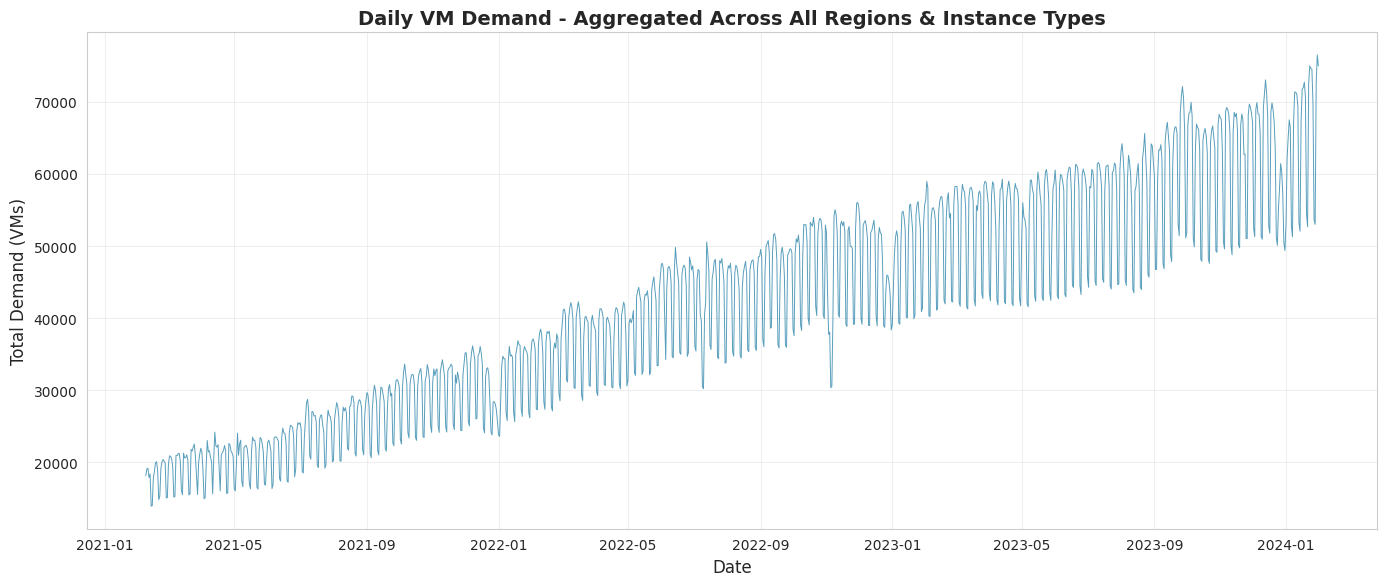

✅ Saved: figures/01_actuals_full_timeseries.png


In [4]:
# PLOT 1: Full time series - the "big picture"
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df['date'], df['demand'], linewidth=0.7, alpha=0.8, color='#2E86AB')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Demand (VMs)', fontsize=12)
ax.set_title('Daily VM Demand - Aggregated Across All Regions & Instance Types', 
             fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/01_actuals_full_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: figures/01_actuals_full_timeseries.png")

---
### Observations

**What do you see?**
- Is there an overall trend (increasing/decreasing)?
- Can you spot regular patterns (weekly dips)?
- Any unusual spikes or drops?
- How volatile is the demand day-to-day?
  
This chart visualizes the Global Demand Signal (total daily usage), revealing a clear upward trend that is disrupted by a distinct "structural break" (a sharp, sustained drop) in mid-2022. The repetitive "sawtooth" shape confirms a rigid weekly pattern, characterized by reliable "weekend dips" where demand falls significantly every Saturday and Sunday. Crucially, the jagged vertical spikes expose high day-to-day volatility, proving that while the business is stable in the long term, daily operations face acute "stockout" risks from sudden surges that a simple average would smooth over.

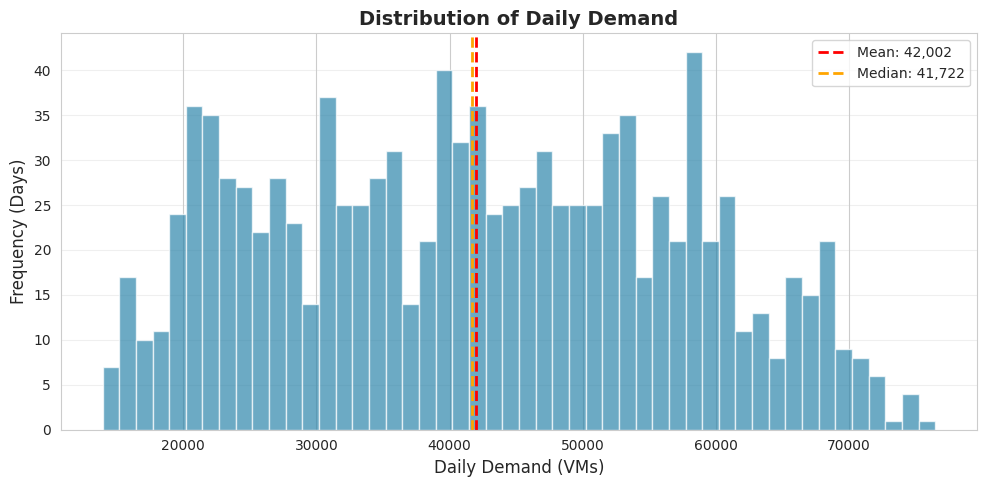

✅ Saved: figures/02_demand_distribution.png


In [5]:
# PLOT 2: Histogram - understand the distribution of daily demand
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(df['demand'], bins=50, alpha=0.7, color='#2E86AB', edgecolor='white') #bin demand across 1000 days into 50 buckets
ax.axvline(df['demand'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['demand'].mean():,.0f}")
ax.axvline(df['demand'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {df['demand'].median():,.0f}")
#get the mean and median demand, mean distracted by outliers, median ignores them
ax.set_xlabel('Daily Demand (VMs)', fontsize=12) 
ax.set_ylabel('Frequency (Days)', fontsize=12)
ax.set_title('Distribution of Daily Demand', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../figures/02_demand_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: figures/02_demand_distribution.png")

# Analysis

This histogram characterizes the probability distribution of daily demand, testing the "Normality Assumption" 
required by many standard forecasting models. The separation between the Mean (Red) and Median (Orange) indicates a Right Skew, 
meaning the dataset is influenced by high-demand "tail events" (spikes) that pull the average upward. This skewness suggests that relying 
on a standard Bell Curve (Normal Distribution) for safety stock calculations may underestimate risk, 
validating our need for a more robust, percentile-based buffer strategy.

/tmp/ipykernel_155/4124054684.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='day_name', y='demand', order=day_order, palette='muted', ax=ax)


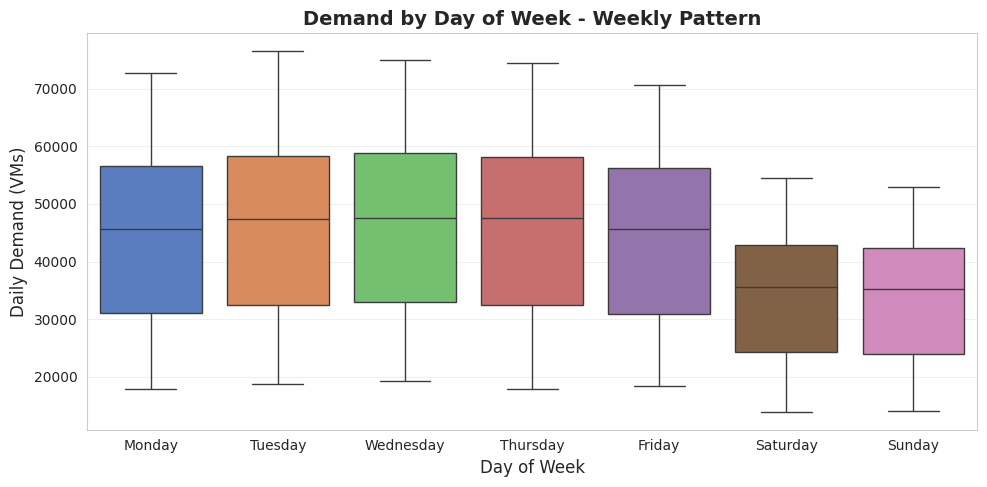

✅ Saved: figures/03_demand_by_weekday.png


In [6]:
# PLOT 3: Boxplot by day of week - Weekly Seasonality Analysis
df['day_of_week'] = df['date'].dt.dayofweek
df['day_name'] = df['date'].dt.day_name()

# Order days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x='day_name', y='demand', order=day_order, palette='muted', ax=ax)

ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Daily Demand (VMs)', fontsize=12)
ax.set_title('Demand by Day of Week - Weekly Pattern', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../figures/03_demand_by_weekday.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: figures/03_demand_by_weekday.png")

This boxplot isolates the weekly seasonality inherent in the dataset, confirming a distinct "Business Week" pattern. 
Demand remains consistently high and volatile (tall interquartile ranges) from Monday through Friday, before dropping significantly on 
Saturday and Sunday. This structural difference between weekdays and weekends validates the use of a 7-day rolling window 
(which captures exactly one full cycle) over arbitrary windows like 3 or 10 days, which would bias the baseline depending on the starting day

You need 500 spare units on Tuesday, but maybe only 50 on Sunday.

---
## Step 3: Add Rolling Averages (Section 2)

> "Rolling averages are a natural baseline that readers expect to see."

We overlay multiple window sizes to show sensitivity:
- **3-day**: Very responsive, noisy
- **7-day**: Captures weekly cycle, moderate lag
- **14-day**: Smoother, more lag
- **28-day**: Very smooth, loses weekly detail

In [7]:
# Calculate rolling averages with multiple windows
windows = [3, 7, 14, 28]
#create a list called windows with the rolling windows we are interested in
#compare multiple baselines, lenient vs strict
for w in windows:
    df[f'ma_{w}'] = df['demand'].rolling(window=w, min_periods=1).mean()
# df[f'ma_{w}'] tells Python: "Create a new column named dynamically."
    # When w=7, this creates df['ma_7']. When w=28, it creates df['ma_28'].
#window=w tells the code: "Only look at the last 'w' days."
    
# Preview
df[['date', 'demand'] + [f'ma_{w}' for w in windows]].head(30)
# By default, a 7-day rolling average returns "NaN" (Blank) for the first 6 days 
        # because it thinks it needs *full* data to start.
        # min_periods=1 tells it: "Don't be pedantic. If you only have 1 day of data, 
        # just give me the average of that 1 day. If you have 2, average those 2."

,date,demand,ma_3,ma_7,ma_14,ma_28
0,2021-02-08,18165.0,18165.000000,18165.000000,18165.000000,18165.000000
1,2021-02-09,19090.0,18627.500000,18627.500000,18627.500000,18627.500000
2,2021-02-10,19195.0,18816.666667,18816.666667,18816.666667,18816.666667
3,2021-02-11,17915.0,18733.333333,18591.250000,18591.250000,18591.250000
4,2021-02-12,18398.0,18502.666667,18552.600000,18552.600000,18552.600000
5,2021-02-13,13938.0,16750.333333,17783.500000,17783.500000,17783.500000
6,2021-02-14,14005.0,15447.000000,17243.714286,17243.714286,17243.714286
7,2021-02-15,17800.0,15247.666667,17191.571429,17313.250000,17313.250000
8,2021-02-16,18750.0,16851.666667,17143.000000,17472.888889,17472.888889
9,2021-02-17,19924.0,18824.666667,17247.142857,17718.000000,17718.000000


Now I am going to run a simulation. I want to see how four different imaginary managers would have handled this inventory.

I will create a Manager 3 who only remembers the last 3 days (very reactive), all the way up to a 
Manager 28 who looks at the last month (very stable). I am using a loop to force all four of 
them to make their decisions at once so I can compare them later."

By creating these four baselines, we are effectively simulating four different operational strategies—ranging from a reactive approach 
that chases every short-term spike (3-day window) to a stable approach that smooths out the noise (28-day window). 
This comparison allows us to visually prove the "Responsiveness vs. Stability" conflict "(Bias-Lag Tradeoff)", 
demonstrating that a simple average always forces us to choose between reacting too slowly to peaks
or overreacting to random bumps. These lines serve as the "Naive Baselines" that our future seasonality model must beat to prove its value.

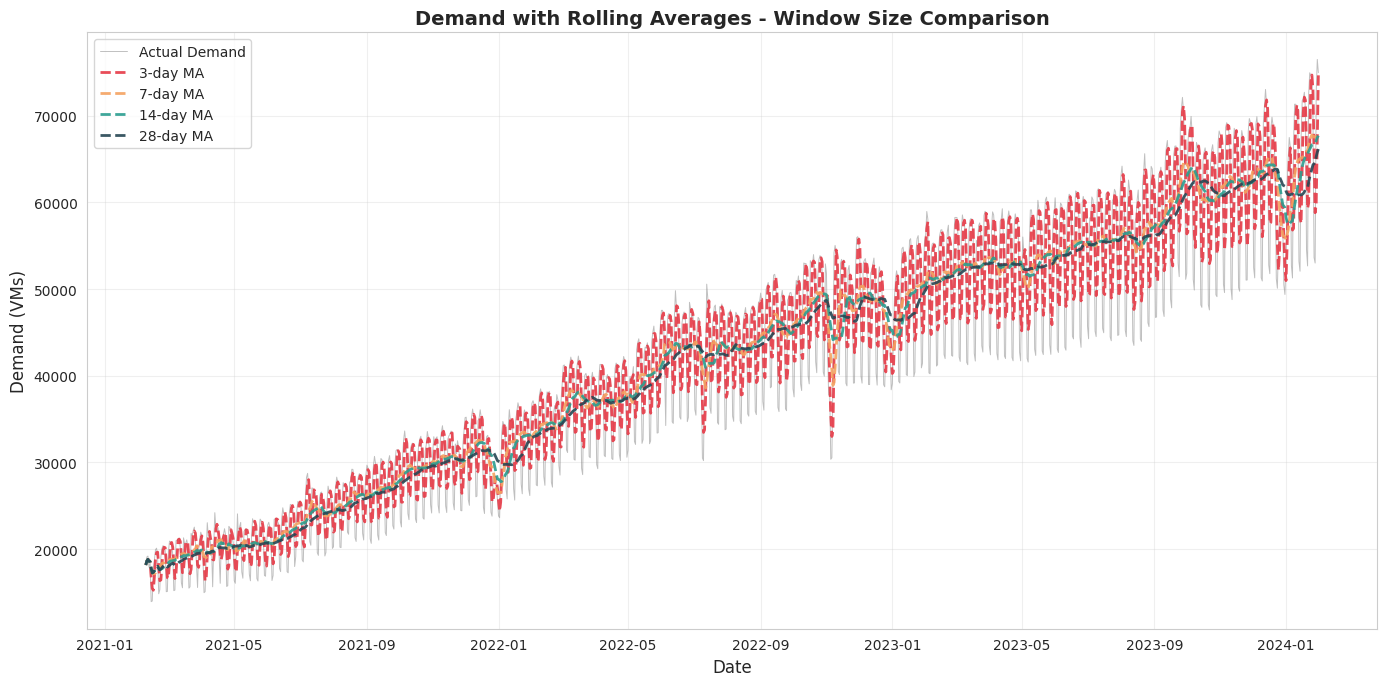

✅ Saved: figures/04_rolling_averages_comparison.png


In [8]:
# PLOT 4: Actuals with all rolling averages overlaid
fig, ax = plt.subplots(figsize=(14, 7))

# Actual demand (thin gray line)
ax.plot(df['date'], df['demand'], label='Actual Demand', 
        linewidth=0.7, alpha=0.5, color='gray')

# Rolling averages (colored dashed lines)
colors = ['#E63946', '#F4A261', '#2A9D8F', '#264653']
for w, color in zip(windows, colors):
    ax.plot(df['date'], df[f'ma_{w}'], label=f'{w}-day MA', 
            linewidth=2, linestyle='--', color=color, alpha=0.9)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Demand (VMs)', fontsize=12)
ax.set_title('Demand with Rolling Averages - Window Size Comparison', 
             fontweight='bold', fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/04_rolling_averages_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: figures/04_rolling_averages_comparison.png")

"Now I am putting all four of my 'managers' (the 3, 7, 14, and 28-day baselines) on the
same chart to see how they compare against reality.

I am effectively conducting a visual backtest. I want to see:
- The Truth (Gray Line): What actually happened? I'll paint this in gray so it sits in the background.
- The Opinions (Colored Lines): What did each manager think should happen?
- The Lag: When demand spiked in July, which manager reacted fast enough, and which one was still asleep?"

This chart illustrates the unavoidable conflict (Bias-Lag Tradeoff) of using simple math to run operations. It shows that while short "memory spans" (smoothing windows) like the 3-day Red line are fast to react (responsive) to spikes, they mistakenly chase random bumps (volatility); meanwhile, longer memory spans like the 28-day Blue line are steady (stable) but have a dangerous delay (lag), failing to notice a trend change until days after it starts. This visually proves that a simple Average is unsafe for keeping the lights on (operational safety) because it forces us to choose between being too jumpy or too slow.

### Key Observations on Window Size

| Window | Characteristic | Trade-off |
|--------|----------------|-----------|
| **3-day** | Very responsive | Noisy, follows every bump |
| **7-day** | Captures weekly pattern | Moderate lag on changes |
| **14-day** | Smoother trend | Significant lag |
| **28-day** | Very smooth | Loses weekly detail entirely |

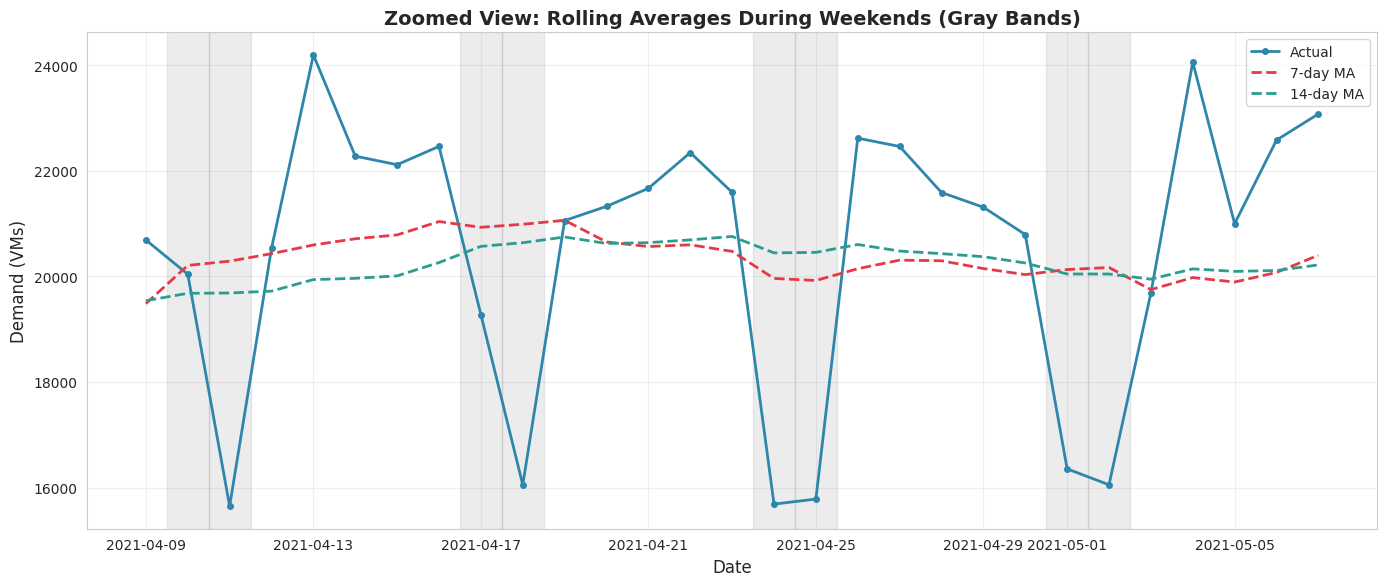

✅ Saved: figures/05_rolling_averages_zoomed.png


In [9]:
# PLOT 5: Zoomed view to see window behavior during demand drops
# Pick a 4-week window to examine closely
sample_start = df['date'].min() + pd.Timedelta(days=60)
sample_end = sample_start + pd.Timedelta(days=28)

sample = df[(df['date'] >= sample_start) & (df['date'] <= sample_end)].copy()

fig, ax = plt.subplots(figsize=(14, 6))

# Actual demand with markers
ax.plot(sample['date'], sample['demand'], label='Actual', 
        linewidth=2, marker='o', markersize=4, color='#2E86AB')

# Rolling averages
for w, color in zip([7, 14], ['#E63946', '#2A9D8F']):
    ax.plot(sample['date'], sample[f'ma_{w}'], label=f'{w}-day MA', 
            linewidth=2, linestyle='--', color=color)

# Highlight weekends
for idx, row in sample[sample['is_weekend'] == True].iterrows():
    ax.axvspan(row['date'] - pd.Timedelta(hours=12), 
               row['date'] + pd.Timedelta(hours=12), 
               alpha=0.15, color='gray')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Demand (VMs)', fontsize=12)
ax.set_title('Zoomed View: Rolling Averages During Weekends (Gray Bands)', 
             fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/05_rolling_averages_zoomed.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: figures/05_rolling_averages_zoomed.png")

### The Over-Forecasting Problem

**Key observation**: During weekends (gray bands), actual demand drops sharply,
but rolling averages stay high because they're averaging past weekdays.

This is **systematic over-forecasting** during demand dips - the core limitation
that Section 2 asks us to demonstrate.

---
## Summary: What We Learned

### Section 1: Plot the Actuals ✓
- Created 3 visualizations: time series, distribution, weekly pattern
- Observed overall behavior and volatility

### Section 2: Rolling Averages as Baselines ✓
- Demonstrated window size sensitivity (3, 7, 14, 28-day)
- Showed the over-forecasting problem during weekend dips
- Rolling averages are baselines for comparison, not forecasts

### What's Next (For Session with Steven)
- **Section 3**: Train-test split to evaluate forecast accuracy
- **Section 4**: Compare rolling average MAPE vs Prophet MAPE
- **Section 6**: Formal holdout evaluation

**Key insight**: We haven't done train-test split yet because we're still
in *exploration* mode. Train-test split is for *evaluation* mode.

In [10]:
# Quick stats for reference
print("=== Summary Statistics ===")
print(f"Total days: {len(df)}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"\nDemand Statistics:")
print(f"  Mean: {df['demand'].mean():,.0f} VMs")
print(f"  Std:  {df['demand'].std():,.0f} VMs")
print(f"  Min:  {df['demand'].min():,.0f} VMs")
print(f"  Max:  {df['demand'].max():,.0f} VMs")
print(f"\nWeekend Effect:")
weekday_avg = df[df['is_weekend'] == False]['demand'].mean()
weekend_avg = df[df['is_weekend'] == True]['demand'].mean()
print(f"  Weekday avg: {weekday_avg:,.0f} VMs")
print(f"  Weekend avg: {weekend_avg:,.0f} VMs")
print(f"  Drop: {(weekday_avg - weekend_avg) / weekday_avg * 100:.1f}%")

=== Summary Statistics ===
Total days: 1088
Date range: 2021-02-08 to 2024-01-31

Demand Statistics:
  Mean: 42,002 VMs
  Std:  15,074 VMs
  Min:  13,938 VMs
  Max:  76,492 VMs

Weekend Effect:
  Weekday avg: 45,205 VMs
  Weekend avg: 33,962 VMs
  Drop: 24.9%
